### Logistic Regression

#### 1. 数据预处理
- 读取数据
- 标准化/归一化

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
# 读取数据
import os
path = 'data' + os.sep + 'LogiReg_data.txt'
pdData = pd.read_csv(path, header=None, names=['Exam 1', 'Exam 2', 'Admitted'])
pdData.head()

,Exam 1,Exam 2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


Text(0, 0.5, 'Exam 2 Score')

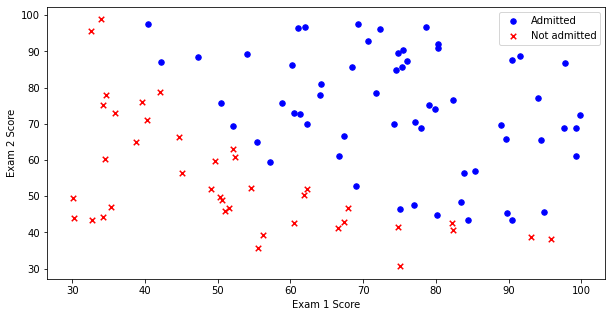

In [13]:
# 初始数据分类图
positive = pdData[pdData['Admitted'] == 1]
negative = pdData[pdData['Admitted'] == 0]

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(positive['Exam 1'], positive['Exam 2'], 
           s=30, c='b', marker='o', label='Admitted')
ax.scatter(negative['Exam 1'], negative['Exam 2'], 
           s=30, c='r', marker='x', label='Not admitted')
ax.legend()
ax.set_xlabel('Exam 1 Score')
ax.set_ylabel('Exam 2 Score')

In [14]:
# 划分X, y
pdData.insert(0, 'Ones', 1)
orig_data = pdData.values
cols = orig_data.shape[1]
X = orig_data[:,0:cols-1]
y = orig_data[:,cols-1:cols]
# 初始化theta
theta = np.zeros([1,3])

In [32]:
# 标准化
from sklearn import preprocessing as pp

scaled_data = orig_data.copy()
scaled_data[:, 1:3] = pp.scale(orig_data[:, 1:3])

#### 2. sigmoid：映射到概率的函数
$$
g(z) = \frac{1}{1+e^{-z}}   
$$
* $g:\mathbb{R} \to [0,1]$
* $g(0)=0.5$
* $g(- \infty)=0$
* $g(+ \infty)=1$

In [33]:
# 定义Sigmoid
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

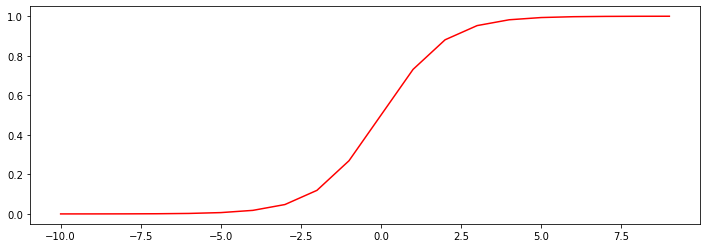

In [34]:
# 画Sigmoid函数
nums = np.arange(-10, 10, step=1) #creates a vector containing 20 equally spaced values from -10 to 10
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(nums, sigmoid(nums), 'r')

#### 3. model：返回预测结果值
$$
\begin{array}{ccc}
\begin{pmatrix}\theta_{0} & \theta_{1} & \theta_{2}\end{pmatrix} & \times & \begin{pmatrix}1\\
x_{1}\\
x_{2}
\end{pmatrix}\end{array}=\theta_{0}+\theta_{1}x_{1}+\theta_{2}x_{2}
$$

In [35]:
# 定义预测函数
def model(X, theta):
    return sigmoid(np.dot(X, theta.T))

#### 4. cost：根据参数计算损失
将对数似然函数去负号

$$
D(h_\theta(x), y) = -y\log(h_\theta(x)) - (1-y)\log(1-h_\theta(x))
$$
求平均损失
$$
J(\theta)=\frac{1}{n}\sum_{i=1}^{n} D(h_\theta(x_i), y_i)
$$

In [36]:
# 定义损失函数
def cost(X, y, theta):
    left = np.multiply(-y, np.log(model(X, theta)))
    right = np.multiply(1 - y, np.log(1 - model(X, theta)))
    return np.sum(left - right) / (len(X))

In [37]:
# 计算当前损失值
cost(X, y, theta)

0.6931471805599453

#### 5. gradient：计算每个参数的梯度方向
$$
\frac{\partial J}{\partial \theta_j}=-\frac{1}{m}\sum_{i=1}^n (y_i - h_\theta (x_i))x_{ij}
$$

In [38]:
# 定义梯度函数
def gradient(X, y, theta):
    grad = np.zeros(theta.shape)
    error = (model(X, theta)- y).ravel()
    for j in range(len(theta.ravel())): #for each parmeter
        term = np.multiply(error, X[:,j])
        grad[0, j] = np.sum(term) / len(X)
    
    return grad

#### 6. descent：进行参数更新
- 批量梯度下降
- 随机梯度下降
- 小批量梯度下降

In [39]:
# 设定三种不同的停止策略
STOP_ITER = 0
STOP_COST = 1
STOP_GRAD = 2

def stopCriterion(type, value, threshold):
    if type == STOP_ITER:      
        return value > threshold
    elif type == STOP_COST:      
        return abs(value[-1]-value[-2]) < threshold
    elif type == STOP_GRAD:      
        return np.linalg.norm(value) < threshold

In [40]:
# 洗牌
import numpy.random
def shuffleData(data):
    np.random.shuffle(data)
    cols = data.shape[1]
    X = data[:, 0:cols-1]
    y = data[:, cols-1:]
    return X, y

In [41]:
# 梯度下降求解
import time

def descent(data, theta, batchSize, stopType, thresh, alpha):
    
    init_time = time.time()
    i = 0 # 迭代次数
    k = 0 # batch
    X, y = shuffleData(data)
    grad = np.zeros(theta.shape) # 计算的梯度
    costs = [cost(X, y, theta)] # 损失值

    
    while True:
        grad = gradient(X[k:k+batchSize], y[k:k+batchSize], theta)
        k += batchSize #取batch数量个数据
        if k >= n: 
            k = 0 
            X, y = shuffleData(data) #重新洗牌
        theta = theta - alpha*grad # 参数更新
        costs.append(cost(X, y, theta)) # 计算新的损失
        i += 1 

        if stopType == STOP_ITER:       value = i
        elif stopType == STOP_COST:     value = costs
        elif stopType == STOP_GRAD:     value = grad
        if stopCriterion(stopType, value, thresh): break
    
    return theta, i-1, costs, grad, time.time() - init_time

In [42]:
# 进行实验
def runExpe(data, theta, batchSize, stopType, thresh, alpha):
    theta, iter, costs, grad, dur = descent(data, theta, batchSize, stopType, thresh, alpha)
    name = "Original" if (data[:,1]>2).sum() > 1 else "Scaled"
    name += " data - learning rate: {} - ".format(alpha)
    if batchSize==n: strDescType = "Gradient"
    elif batchSize==1:  strDescType = "Stochastic"
    else: strDescType = "Mini-batch ({})".format(batchSize)
    name += strDescType + " descent - Stop: "
    if stopType == STOP_ITER: strStop = "{} iterations".format(thresh)
    elif stopType == STOP_COST: strStop = "costs change < {}".format(thresh)
    else: strStop = "gradient norm < {}".format(thresh)
    name += strStop
    print ("***{}\nTheta: {} - Iter: {} - Last cost: {:03.2f} - Duration: {:03.2f}s".format(
        name, theta, iter, costs[-1], dur))
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(np.arange(len(costs)), costs, 'r')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Cost')
    ax.set_title(name.upper() + ' - Error vs. Iteration')
    return theta

##### 6.1 比较三种停止策略

###### 6.1.1 根据迭代次数停止

***Original data - learning rate: 1e-06 - Gradient descent - Stop: 5000 iterations
Theta: [[-0.00027127  0.00705232  0.00376711]] - Iter: 5000 - Last cost: 0.63 - Duration: 0.68s


array([[-0.00027127,  0.00705232,  0.00376711]])

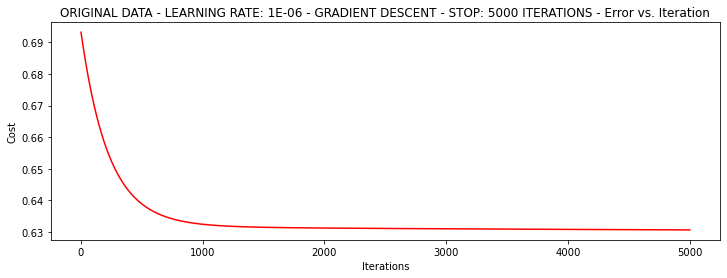

In [44]:
# 选择批量梯度下降
n=100
runExpe(orig_data, theta, n, STOP_ITER, thresh=5000, alpha=0.000001)

###### 6.1.2 根据损失值停止
设定阈值 1E-6, 差不多需要110 000次迭代

***Original data - learning rate: 0.001 - Gradient descent - Stop: costs change < 1e-06
Theta: [[-5.13364014  0.04771429  0.04072397]] - Iter: 109901 - Last cost: 0.38 - Duration: 13.86s


array([[-5.13364014,  0.04771429,  0.04072397]])

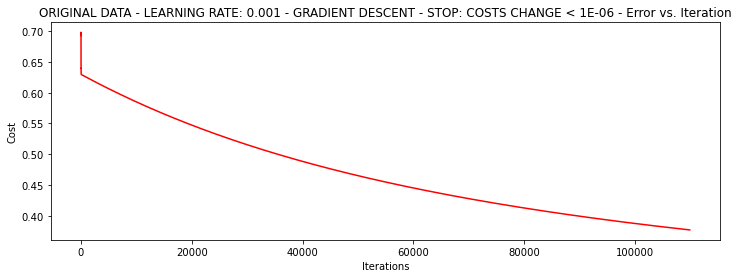

In [45]:
runExpe(orig_data, theta, n, STOP_COST, thresh=0.000001, alpha=0.001)

###### 6.1.3 根据梯度变化停止
设定阈值 0.05,差不多需要40 000次迭代

***Original data - learning rate: 0.001 - Gradient descent - Stop: gradient norm < 0.05
Theta: [[-2.37033409  0.02721692  0.01899456]] - Iter: 40045 - Last cost: 0.49 - Duration: 5.65s


array([[-2.37033409,  0.02721692,  0.01899456]])

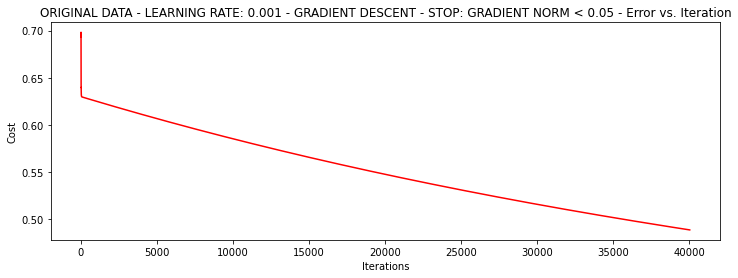

In [46]:
runExpe(orig_data, theta, n, STOP_GRAD, thresh=0.05, alpha=0.001)

##### 6.2 比较三种梯度下降方法

###### 6.2.1 Batch Gradient Descent

***Original data - learning rate: 0.001 - Gradient descent - Stop: 5000 iterations
Theta: [[-0.34172467  0.01280219  0.00311026]] - Iter: 5000 - Last cost: 0.61 - Duration: 0.65s


array([[-0.34172467,  0.01280219,  0.00311026]])

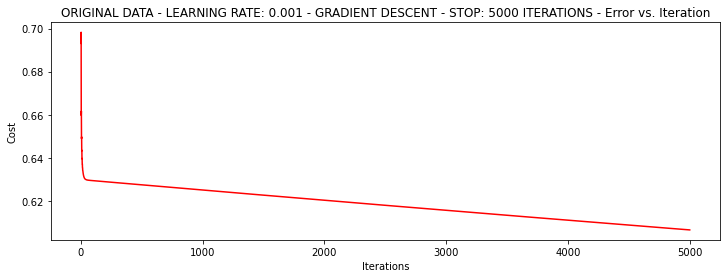

In [47]:
runExpe(orig_data, theta, 100, STOP_ITER, thresh=5000, alpha=0.001)

###### 6.2.2 Stochastic descent

***Original data - learning rate: 0.001 - Stochastic descent - Stop: 5000 iterations
Theta: [[-0.38717522  0.03023445 -0.07852445]] - Iter: 5000 - Last cost: 2.43 - Duration: 0.25s


array([[-0.38717522,  0.03023445, -0.07852445]])

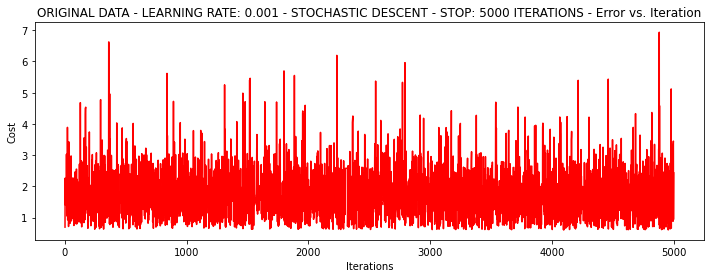

In [48]:
runExpe(orig_data, theta, 1, STOP_ITER, thresh=5000, alpha=0.001)

***Original data - learning rate: 2e-06 - Stochastic descent - Stop: 15000 iterations
Theta: [[-0.00202199  0.00999201  0.00089676]] - Iter: 15000 - Last cost: 0.63 - Duration: 0.71s


array([[-0.00202199,  0.00999201,  0.00089676]])

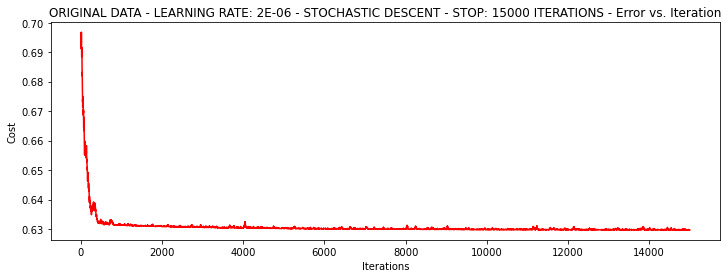

In [49]:
runExpe(orig_data, theta, 1, STOP_ITER, thresh=15000, alpha=0.000002)

***Scaled data - learning rate: 0.001 - Stochastic descent - Stop: gradient norm < 0.0004
Theta: [[1.14806982 2.79300996 2.56582397]] - Iter: 72593 - Last cost: 0.22 - Duration: 4.65s


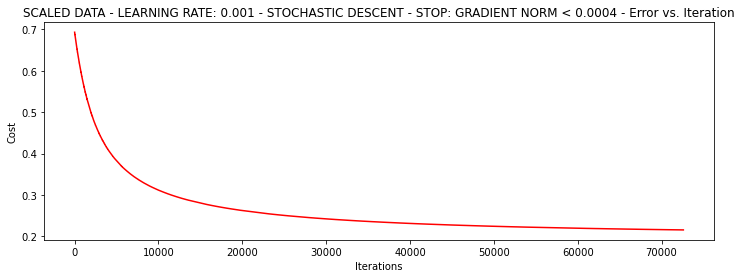

In [64]:
theta = runExpe(scaled_data, theta, 1, STOP_GRAD, thresh=0.002/5, alpha=0.001)

###### 6.2.3 Mini-batch descent

***Original data - learning rate: 0.001 - Mini-batch (16) descent - Stop: 15000 iterations
Theta: [[-1.03399875e+00  1.06396847e-02 -8.60279869e-04]] - Iter: 15000 - Last cost: 0.70 - Duration: 0.94s


array([[-1.03399875e+00,  1.06396847e-02, -8.60279869e-04]])

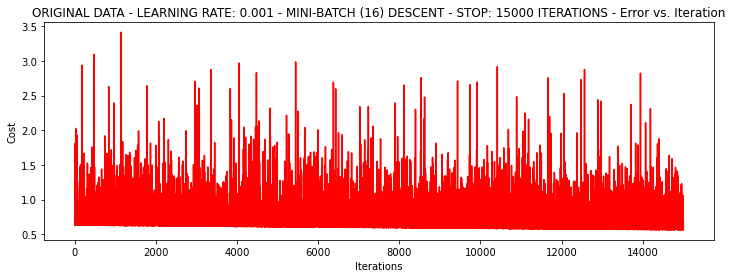

In [50]:
runExpe(orig_data, theta, 16, STOP_ITER, thresh=15000, alpha=0.001)

***Scaled data - learning rate: 0.001 - Mini-batch (16) descent - Stop: 5000 iterations
Theta: [[0.31279616 0.8653289  0.77302035]] - Iter: 5000 - Last cost: 0.38 - Duration: 0.38s


array([[0.31279616, 0.8653289 , 0.77302035]])

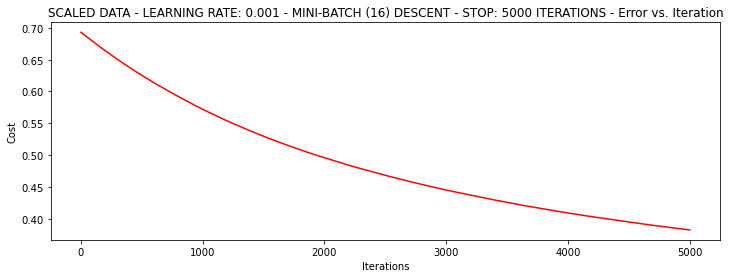

In [58]:
runExpe(scaled_data, theta, 16, STOP_ITER, thresh=5000, alpha=0.001)

***Scaled data - learning rate: 0.001 - Mini-batch (16) descent - Stop: gradient norm < 0.02
Theta: [[0.67315983 1.76959334 1.60090874]] - Iter: 19947 - Last cost: 0.26 - Duration: 1.62s


array([[0.67315983, 1.76959334, 1.60090874]])

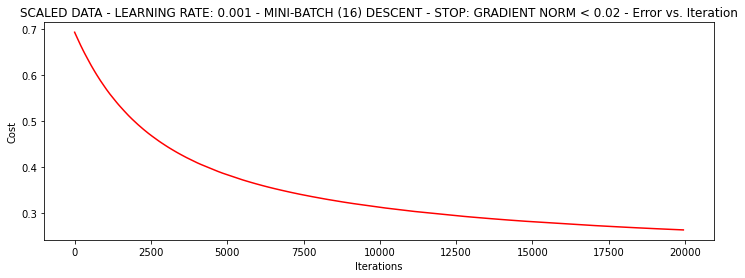

In [59]:
runExpe(scaled_data, theta, 16, STOP_GRAD, thresh=0.02, alpha=0.001)

***Scaled data - learning rate: 0.001 - Mini-batch (16) descent - Stop: gradient norm < 0.004
Theta: [[1.02054639 2.51875264 2.31108854]] - Iter: 52061 - Last cost: 0.22 - Duration: 3.95s


array([[1.02054639, 2.51875264, 2.31108854]])

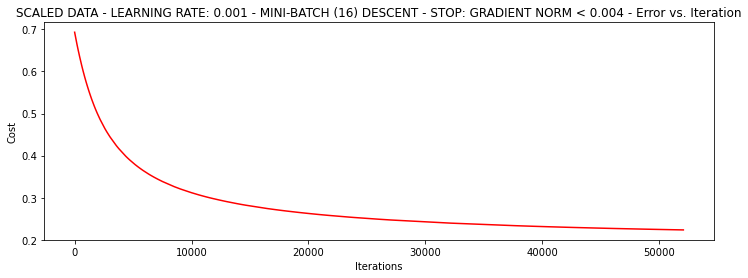

In [60]:
runExpe(scaled_data, theta, 16, STOP_GRAD, thresh=0.002*2, alpha=0.001)

#### 7. accuracy：计算精度

In [66]:
#设定阈值
def predict(X, theta):
    return [1 if x >= 0.5 else 0 for x in model(X, theta)]

In [67]:
scaled_X = scaled_data[:, :3]
y = scaled_data[:, 3]
predictions = predict(scaled_X, theta)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y)]
accuracy = (sum(map(int, correct)) % len(correct))
print ('accuracy = {0}%'.format(accuracy))

accuracy = 89%
